<h1><b> Sports Action Recognition Using CNN and LSTM : Team Epsilon </b></h1>

In [1]:
%%capture
!pip install pafy youtube-dl moviepy os cv2 sklearn

In [ ]:
!pip install opencv-python numpy datetime tensorflow

In [ ]:
!pip install pafy
!pip install moviepy


<h2>Importing Necessory Libraries</h2>

In [5]:


import os
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

<h2>Set Random Seed Value Constant thorugh out the program</h2>

In [6]:
import numpy as np
import random
import tensorflow as tf
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [12]:
data_dir = 'data_dir' # Dataset Path

<h2>Plotting Some of the Samples</h2>

In [ ]:
plt.figure(figsize=(20, 20))

# Get the class names (subdirectories)
classes_names = os.listdir(data_dir)

# Determine the sample size to take
sample_size = min(20, len(classes_names))  # Sample only up to the number of available classes

# Generate random indices
random_range = random.sample(range(len(classes_names)), sample_size)

for counter, random_index in enumerate(random_range, 1):
    select_class_name = classes_names[random_index]
    
    # List video files in the selected class directory
    video_file_name_list = os.listdir(os.path.join(data_dir, select_class_name))
    
    # Select a random video file
    select_video_file = random.choice(video_file_name_list)
    
    # Open the video file
    video_reader = cv2.VideoCapture(os.path.join(data_dir, select_class_name, select_video_file))

    # Read the first frame of the video
    ret, bgr_frame = video_reader.read()

    # Break the loop if there are no frames left
    if not ret:
        print(f"Error: Could not read frame from {select_video_file}")
        continue  # Skip to the next iteration if the frame could not be read

    # Release the video reader
    video_reader.release()

    # Convert the frame from BGR to RGB
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # Add the class name as text on the frame
    cv2.putText(rgb_frame, select_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    # Display the frame
    plt.subplot(5, 4, counter)
    plt.imshow(rgb_frame)
    plt.axis('off')

# Show the plot with the frames
plt.show()

In [63]:
classes_names

['BaseballPitch',
 'Basketball',
 'Billiards',
 'GolfSwing',
 'JavelinThrow',
 'TennisSwing',
 'ThrowDiscus',
 'VolleyballSpiking']

In [21]:
img_height, img_width = 64, 64

In [14]:
# number opf frames of video that will be fed to the model as one sequence

sequence_length = 20 

DATASET_DIR = data_dir

classes_list = ['BaseballPitch',
 'Basketball',
 'Billiards',
 'GolfSwing',
 'JavelinThrow',
 'TennisSwing',
 'ThrowDiscus',
 'VolleyballSpiking']

# Frame Extraction

In [67]:
def frame_extraction(video_path):

    frame_list = []

    video_reader = cv2.VideoCapture(video_path)
    video_frame_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frame_window = max(int(video_frame_count/sequence_length), 1)

    for frame_counter  in range(sequence_length):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frame_window)
        success, frame = video_reader.read()

        if not success:
            break
        resize_frame = cv2.resize(frame, (img_height, img_width))
        normalized_frame = resize_frame/225
        frame_list.append(normalized_frame)

    video_reader.release()

    return frame_list

# creating a dataset by using the classes name and the file path

In [69]:
def create_dataset():
    features = []
    labels = []
    video_file_paths = []

    for class_index, class_name in enumerate(classes_list):
        print("Extracting data of Class: ",class_name)

        files_list = os.listdir(os.path.join(data_dir, class_name))


        for file_name  in files_list:
            video_file_path = os.path.join(data_dir, class_name, file_name)
            frames = frame_extraction(video_file_path)

            if len(frames) == sequence_length:
                features.append(frames)
                labels.append(class_index)
                video_file_paths.append(video_file_path)


    features = np.asarray(features)
    labels =np.array(labels)

    return features, labels, video_file_paths
                

In [ ]:
def Visualize_Dataset_Distribution(self, Data_Path):
        Length_Of_All_Classes = {}
        Class_Names = [i for i in os.listdir(Data_Path)]
        Count = 0

        for Classes in os.listdir(Data_Path):
            Class_Path = os.path.join(Data_Path, Classes)
            Length_Of_All_Classes[Class_Names[Count]] = len(os.listdir(Class_Path))
            Count += 1

        Length = [length for length in Length_Of_All_Classes.values()]
        Names = [names for names in Length_Of_All_Classes.keys()]

        plt.figure(figsize=(10, 5))
        plt.bar(Names, Length, width=0.4, color='skyblue')
        plt.ylabel('Number of Samples')
        plt.title('Dataset Distribution - Bar Chart')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(8, 8))
        plt.pie(Length, labels=Names, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
        plt.title('Dataset Distribution - Pie Chart')
        plt.axis('equal')
        plt.show()

In [71]:
# by running this you can create you own specific categories dataset

features, labels, video_file_paths = create_dataset()

Extracting data of Class:  BaseballPitch
Extracting data of Class:  Basketball
Extracting data of Class:  Billiards
Extracting data of Class:  GolfSwing
Extracting data of Class:  JavelinThrow
Extracting data of Class:  TennisSwing
Extracting data of Class:  ThrowDiscus
Extracting data of Class:  VolleyballSpiking


In [74]:
# converting labels into on-hot encoding vectors

one_hot_encoding_labels = to_categorical(labels)

# data Spliting

In [76]:
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoding_labels, 
                                                                            test_size = 0.20, shuffle= True,
                                                                            random_state = 42)

In [112]:
from keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Dropout, Flatten, LSTM, Dense, Input

In [124]:
def create_LRCN_model(sequence_length, img_height, img_width, num_classes):
    model = Sequential()
    model.add(Input(shape=(sequence_length, img_height, img_width, 3)))  # Define the input shape here
    model.add(TimeDistributed(Conv2D(16, (3, 3), padding="same", activation="relu")))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(32, (3,3), padding= "same", activation= "relu")))
    model.add(TimeDistributed(MaxPooling2D((2,2))))
    model.add(TimeDistributed(Dropout(0.25)))


    model.add(TimeDistributed(Conv2D(64, (3,3), padding= "same", activation= "relu")))
    model.add(TimeDistributed(MaxPooling2D((2,2))))
    model.add(TimeDistributed(Dropout(0.25)))


    model.add(TimeDistributed(Conv2D(64, (3,3), padding= "same", activation= "relu")))
    model.add(TimeDistributed(MaxPooling2D((2,2))))

    
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(32))  # Ensure LSTM is defined
    model.add(Dense(num_classes, activation='softmax'))  # Use num_classes for output layer

    return model

In [126]:
sequence_length = 20  # Example value
img_height = 64       # Example value
img_width = 64        # Example value
num_classes = 8       # Example number of classes
LRCN_model = create_LRCN_model(sequence_length, img_height, img_width, num_classes)
print("Model Created Successfully")

Model Created Successfully


In [128]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)

LRCN_model.compile(loss = "categorical_crossentropy", optimizer = "Adam", metrics =["accuracy"])

LRCN_model_training_history = LRCN_model.fit(x = features_train, y=labels_train, epochs = 50, batch_size = 16, shuffle = True,
                                                     validation_split = 0.2,
                                                     callbacks= [early_stopping_callback])

Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 57s 852ms/step - accuracy: 0.1978 - loss: 2.0785 - val_accuracy: 0.3371 - val_loss: 1.7714
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 35s 782ms/step - accuracy: 0.4395 - loss: 1.5592 - val_accuracy: 0.4494 - val_loss: 1.4649
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 35s 786ms/step - accuracy: 0.4786 - loss: 1.3609 - val_accuracy: 0.5337 - val_loss: 1.2525
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 36s 787ms/step - accuracy: 0.5557 - loss: 1.1889 - val_accuracy: 0.5562 - val_loss: 1.2293
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 36s 798ms/step - accuracy: 0.5570 - loss: 1.1901 - val_accuracy: 0.5899 - val_loss: 1.2495
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 36s 790ms/step - accuracy: 0.5856 - loss: 1.0965 - val_accuracy: 0.5730 - val_loss: 1.2041
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 36s 790ms/step - accuracy: 0.6756 - loss: 0.9315 - val_accuracy: 0.6348 - val_loss: 1.0464
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 36s 797ms/step - accuracy: 0.7242 - loss: 0.8390 - val_accu

In [130]:
LRCN_model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.8753 - loss: 0.4216


In [134]:
model_file_name = f'LRCN_model.keras'
convlstm_model.save(model_file_name)

In [140]:
def plot_metric(LRCN_model_evaluation_history, metric_name_1, metric_name_2, plot_name):

    metric_value_1 = LRCN_model_evaluation_history.history[metric_name_1]
    metric_value_2 = LRCN_model_evaluation_history.history[metric_name_2]

    epochs = range(len(metric_value_1))

    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    plt.title(str(plot_name))

    plt.legend()

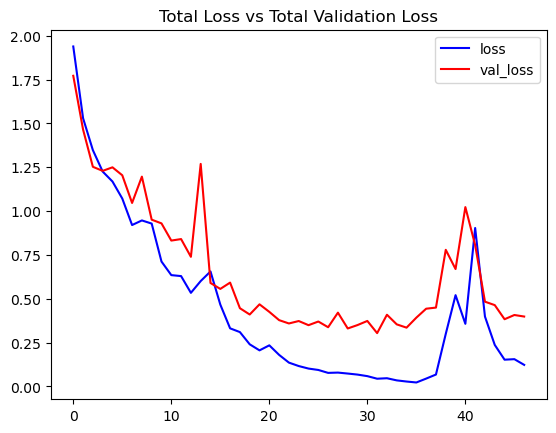

In [142]:
plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

# Model Accuracy 

In [146]:

def plot_metric(training_history, metric_name_1, metric_name_2, plot_name):
    metric_value_1 = training_history.history[metric_name_1]
    metric_value_2 = training_history.history[metric_name_2]

    epochs = range(len(metric_value_1))

    plt.plot(epochs, metric_value_1, label=metric_name_1)
    plt.plot(epochs, metric_value_2, label=metric_name_2)
    plt.title(plot_name)
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

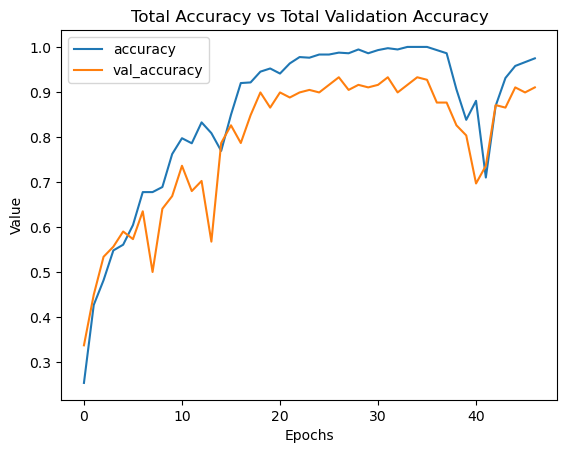

In [148]:
plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')


In [26]:
import tensorflow as tf
from tensorflow.keras.models import load_model
# Load the model
model = load_model('model.h5')


In [27]:
import cv2
import numpy as np
import random

# Function to capture a random frame from the video and make a prediction
def predict_random_frame(video_path, model, img_size=(64, 64), num_frames=20):
    class_names = ['BaseballPitch', 'Basketball', 'Billiards', 'GolfSwing', 'JavelinThrow', 'TennisSwing', 'ThrowDiscus', 'VolleyballSpiking']
    
    # Capture the video
    cap = cv2.VideoCapture(video_path)
    
    # Get the total number of frames in the video
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Randomly select a frame index
    frame_to_capture = random.randint(0, total_frames - 1)
    
    # Set the video to the chosen random frame
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_to_capture)
    
    ret, frame = cap.read()
    if not ret:
        print("Error: Could not read the frame.")
        return None
    
    # Resize and normalize the selected frame
    frame_resized = cv2.resize(frame, img_size)
    frame_normalized = frame_resized / 255.0  # Normalize the frame to [0,1]
    
    # Repeat the frame to create a sequence of exactly 20 frames
    frame_sequence = np.repeat(np.expand_dims(frame_normalized, axis=0), num_frames, axis=0)
    
    # Preprocess frames for the model
    frame_sequence = np.expand_dims(frame_sequence, axis=0)  # Add batch dimension to create shape (1, 20, 64, 64, 3)

    # Predict the class
    predictions = model.predict(frame_sequence)
    predicted_class_index = np.argmax(predictions)
    
    # Get the class name
    predicted_class_name = class_names[predicted_class_index]
    
    # Release the video capture object
    cap.release()
    
    return predicted_class_name


# Function to play the video and display the predicted class name on top
def play_video_with_prediction(video_path, predicted_class_name):
    # Capture the video
    cap = cv2.VideoCapture(video_path)
    
    # Get the FPS to control playback speed
    fps = cap.get(cv2.CAP_PROP_FPS)
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        # Add text to the frame (the predicted class)
        font = cv2.FONT_HERSHEY_SIMPLEX
        text = f'{predicted_class_name}'
        font_scale = 1
        color = (255, 0, 0)  # Red color
        thickness = 2
        position = (50, 50)  # Position of the text on the video frame
        
        # Add the predicted class name to the frame
        frame = cv2.putText(frame, text, position, font, font_scale, color, thickness, cv2.LINE_AA)
        
        # Display the frame
        cv2.imshow('Video with Prediction', frame)
        
        # Wait for the appropriate time between frames based on FPS
        if cv2.waitKey(int(1000 / fps)) & 0xFF == ord('q'):
            break
    
    cap.release()
    cv2.destroyAllWindows()

In [29]:
video_path = 'data_dir/1.avi'
predicted_class = predict_random_frame(video_path, model)
play_video_with_prediction(video_path, predicted_class)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
